<a href="https://colab.research.google.com/github/faithNassiwa/ner-clinicaltrials-interventions/blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS 6120: Natural Language Processing - Prof. Ahmad Uzair

## Project: Semi-Supervised Named Entity Recognition and Classification on Clinical Trial Interventions using BERT
## Group 8: Faith Nassiwa


In [82]:
# Install Packages
import requests
from pprint import pprint
import pandas as pd
import numpy as np

## Get Intervention Names from Clinical Trials(CT.GOV)

In [8]:
import requests, io
import pandas as pd
# Ref: https://www.lexjansen.com/phuse/2021/dh/PRE_DH01.pdf

# Send and retrieve HTTP (REST) request
url = 'https://clinicaltrials.gov/api/query/study_fields?expr=AREA[InterventionType]Drug&fields=NCTId,Condition,InterventionName,InterventionOtherName&min_rnk=1&max_rnk=100&fmt=csv'
res = requests.get(url).content
# Extract contents, skip CSV header (first 10 lines), to dataframe
data = pd.read_csv(io.StringIO(res.decode("utf-8")), skiprows=10).fillna(0)

In [9]:
# Export extracted data for future reference
data.to_csv('data.csv')

In [10]:
# peak at head
data.head(10)

,Rank,NCTId,Condition,InterventionName,InterventionOtherName
0,1,NCT06163170,Melanoma,Nivolumab +/- ipilimumab|Nivolumab,0
1,2,NCT06163040,Relapsed or Refractory Multiple Myeloma,Elotuzumab in combination with pomalidomide an...,0
2,3,NCT06162819,Migraine|Prophylaxis,Amitriptyline|Flunarizine 5mg,Amyline|Sibelium
3,4,NCT06162455,Nosocomial Pneumonia,Sham treatment|200- ppm NO,Oxygen-Air Mixture|Nitric Oxide
4,5,NCT06162286,Community-acquired Bacterial Pneumonia,Omadacycline|Moxifloxacin,0
5,6,NCT06161870,Severe Infection,individualized vancomycin dosing based on the ...,0
6,7,NCT06161844,Type 2 Diabetes Mellitus,semaglutide injection (HD1916)|Ozempic,0
7,8,NCT06161805,Endometriosis|Chronic Pelvic Pain Syndrome,Esketamine hydrochloride|Placebo,ketanest
8,9,NCT06161792,Hot Flashes|Breast Cancer,0.8 mg RCN3028|Placebo,0
9,10,NCT06161714,Pain,Articaine 4%/Epi 1:100000 Inj Cart 1.7Ml|Lidoc...,Septanest|Octocaine


## Preprocessing Intervention Names

In [83]:
import re
def clean_intervention_names(name):
  # split on | and +
  cleaned_names_list = re.split('[\||\+]', name)
  return cleaned_names_list

In [12]:
intervention_names_cleaned = []
for i in data['InterventionName']:
  # remove duplicates if they exist
  intervention_names_cleaned.append(clean_intervention_names(i))

print(len(intervention_names_cleaned))
print(intervention_names_cleaned)

100
[['Nivolumab ', '/- ipilimumab', 'Nivolumab'], ['Elotuzumab in combination with pomalidomide and dexamethasone', 'Elotuzumab in combination with lenalidomide and dexamethasone'], ['Amitriptyline', 'Flunarizine 5mg'], ['Sham treatment', '200- ppm NO'], ['Omadacycline', 'Moxifloxacin'], ['individualized vancomycin dosing based on the population pharmacokinetics (PK) model', 'empirical vancomycin dosing'], ['semaglutide injection (HD1916)', 'Ozempic'], ['Esketamine hydrochloride', 'Placebo'], ['0.8 mg RCN3028', 'Placebo'], ['Articaine 4%/Epi 1:100000 Inj Cart 1.7Ml', 'Lidocaine 2%/Epi 1:100000 Inj Cart 1.7Ml'], ['Efruxifermin', 'Placebo'], ['Sacituzumab govitecan', 'Atezolizumab'], ['ZEN003694', 'Niraparib'], ['Fluzoparib', 'Fluzoparib', 'Apatinib'], ['TQ-A3334 tablets', 'TQ-A3334 placebo tablets'], ['Phase 1 Part A - dose escalation TYRA-200 taken once daily by mouth in 28-day cycles', 'Phase 1 Part B - dose expansion TYRA-200 taken once daily by mouth in 28-day cycles'], ['Belantama

In [13]:
intervention_names_other_cleaned = []
for i in data['InterventionOtherName']:
  if i != 0:
    # remove duplicates if they exist
    intervention_names_other_cleaned.append(clean_intervention_names(i))
  else:
    intervention_names_other_cleaned.append(i)

print(len(intervention_names_other_cleaned))
print(intervention_names_other_cleaned)

100
[0, 0, ['Amyline', 'Sibelium'], ['Oxygen-Air Mixture', 'Nitric Oxide'], 0, 0, 0, ['ketanest'], 0, ['Septanest', 'Octocaine'], 0, 0, ['MK-4827', 'Zejula'], 0, 0, 0, ['GSK2857916', 'aOX40'], 0, ['Singletine（DC407）experimental group', 'Placebo group'], 0, 0, 0, 0, 0, 0, 0, ['Zyprexa', 'Clozaril'], 0, ['ABBV-181'], 0, ['Sprix'], 0, 0, 0, ['Vasopressor', 'Vasopressor'], ['Vasopressor', 'Vasopressor'], ['Vasopressor', 'Vasopressor'], ['Vasopressor', 'Vasopressor'], 0, 0, ['RC48, RC48-ADC', 'TUKYSA, ONT-380, ARRY-380'], 0, ['Traditional Chinese medicine', 'Strandard treatment'], ['QPX7831'], ['Dacogen', 'Venclyxto', 'Venclexta'], ['Tpoxx Tecovirimat', 'Oral placebo capsule'], ['Single arm', 'combinationarm', 'combinationarm'], 0, 0, 0, 0, ['Oral melatonin', 'Placebo'], ['Farxiga', 'Forxiga', 'Cellcept', 'Imuran'], ['cold cream', 'cold cream'], ['Disitamab Vedotin （RC48-ADC)'], 0, ['anastrazole', 'Tamoxifen Citrate', 'NOLVADEX', 'L phenylalanine mustard (P)', 'Fluorouracil (f)'], ['1', '0'

## Use BERN2 to get Drug Name Labels

In [79]:
# Extract drug names from intervention names using BERN2, these will be used as true labels
def extract_drug_name(text, url="http://bern2.korea.ac.kr/plain"):
    response = requests.post(url, json={'text': text})
    if response.status_code == 200:
      result = response.json()
      if len(result['annotations']) > 0:
        mentions = [annotation['mention'] for annotation in result['annotations'] if annotation['obj'] == 'drug']
        return mentions
      else:
        return 'No drug mentioned'
    else:
      return 'Request failed'

if __name__ == '__main__': #test
    text = "Aspirin can be used to reduce the risk of stroke and heart attack."
    pprint(extract_drug_name(text))

['Aspirin']


In [ ]:
bern2_drug_names = []
for i in data['InterventionName']:
  bern2_drug_names.append(extract_drug_name(i)) # stopped after 3 hours of run to be able to proceed after processing 78 rows

print(len(bern2_drug_names))
print(bern2_drug_names)

In [16]:
bern2_drug_names

[['Nivolumab', 'ipilimumab', 'Nivolumab'],
 ['pomalidomide', 'dexamethasone', 'lenalidomide', 'dexamethasone'],
 ['Amitriptyline', 'Flunarizine'],
 'Request failed',
 ['Omadacycline', 'Moxifloxacin'],
 ['vancomycin', 'vancomycin'],
 [],
 ['Esketamine hydrochloride'],
 ['RCN3028'],
 ['Articaine', 'Lidocaine'],
 ['Efruxifermin'],
 [],
 ['ZEN003694', 'Niraparib'],
 ['Fluzoparib', 'Fluzoparib', 'Apatinib'],
 ['TQ-A3334', 'TQ-A3334'],
 ['TYRA-200', 'TYRA-'],
 ['Belantamab', 'GSK3174998'],
 ['CC-42344'],
 ['Singletine'],
 ['Psilocybin', 'psilocybin'],
 [],
 'No drug mentioned',
 'Request failed',
 'Request failed',
 [],
 ['Pacritinib', 'Azacitidine'],
 ['Olanzapine', 'Clozapine'],
 'No drug mentioned',
 'Request failed',
 'No drug mentioned',
 ['ketorolac', 'diclofenac'],
 ['Surufatinib'],
 ['Elocta', 'Alprolix'],
 'Request failed',
 ['Norepinephrine', 'Phenylephrine'],
 ['Norepinephrine', 'Phenylephrine'],
 ['Norepinephrine', 'Phenylephrine'],
 ['Norepinephrine', 'Phenylephrine'],
 ['lenvat

In [17]:
len(bern2_drug_names)

78

In [22]:
dataset = {'intervention_names': data['InterventionName'][:78], 'processed_intervention_names': intervention_names_cleaned[:78], 'target': bern2_drug_names }
dataset

{'intervention_names': 0                    Nivolumab +/- ipilimumab|Nivolumab
 1     Elotuzumab in combination with pomalidomide an...
 2                         Amitriptyline|Flunarizine 5mg
 3                            Sham treatment|200- ppm NO
 4                             Omadacycline|Moxifloxacin
                             ...                        
 73                                Paracetamol|Ibuprofen
 74                                      AZD9550|Placebo
 75         Alpha Lipoic Acid 600 MG Oral Tablet|Placebo
 76                                   AGN-151586|Placebo
 77                 THYROX (Atlantic krill oil).|Placebo
 Name: InterventionName, Length: 78, dtype: object,
 'processed_intervention_names': [['Nivolumab ', '/- ipilimumab', 'Nivolumab'],
  ['Elotuzumab in combination with pomalidomide and dexamethasone',
   'Elotuzumab in combination with lenalidomide and dexamethasone'],
  ['Amitriptyline', 'Flunarizine 5mg'],
  ['Sham treatment', '200- ppm NO'],
  ['O

In [31]:
# Prepare dataset
dataset_df = pd.DataFrame(dataset)

# Remove rows where target == Request failed or []
dataset_df = dataset_df[dataset_df['target'] != 'Request failed']
dataset_df = dataset_df[dataset_df['target'].apply(lambda x: x != [])]
dataset_df.head(10)

,intervention_names,processed_intervention_names,target
0,Nivolumab +/- ipilimumab|Nivolumab,"[Nivolumab , /- ipilimumab, Nivolumab]","[Nivolumab, ipilimumab, Nivolumab]"
1,Elotuzumab in combination with pomalidomide an...,[Elotuzumab in combination with pomalidomide a...,"[pomalidomide, dexamethasone, lenalidomide, de..."
2,Amitriptyline|Flunarizine 5mg,"[Amitriptyline, Flunarizine 5mg]","[Amitriptyline, Flunarizine]"
4,Omadacycline|Moxifloxacin,"[Omadacycline, Moxifloxacin]","[Omadacycline, Moxifloxacin]"
5,individualized vancomycin dosing based on the ...,[individualized vancomycin dosing based on the...,"[vancomycin, vancomycin]"
7,Esketamine hydrochloride|Placebo,"[Esketamine hydrochloride, Placebo]",[Esketamine hydrochloride]
8,0.8 mg RCN3028|Placebo,"[0.8 mg RCN3028, Placebo]",[RCN3028]
9,Articaine 4%/Epi 1:100000 Inj Cart 1.7Ml|Lidoc...,"[Articaine 4%/Epi 1:100000 Inj Cart 1.7Ml, Lid...","[Articaine, Lidocaine]"
10,Efruxifermin|Placebo,"[Efruxifermin, Placebo]",[Efruxifermin]
12,ZEN003694|Niraparib,"[ZEN003694, Niraparib]","[ZEN003694, Niraparib]"


In [32]:
dataset_df.to_csv('dataset.csv')

In [80]:
# Extract drug names from intervention names using BERN2, these will be used as true labels
def extract_drug_name(text, url="http://bern2.korea.ac.kr/plain"):
    response = requests.post(url, json={'text': text})
    if response.status_code == 200:
      result = response.json()
      if len(result['annotations']) > 0:
        mentions = [annotation['mention'] for annotation in result['annotations'] if annotation['obj'] == 'drug']
        return result['annotations']
      else:
        return 'No drug mentioned'
    else:
      return 'Request failed'

if __name__ == '__main__': #test
    text = "Nivolumab +/- ipilimumab|Nivolumab"
    pprint(extract_drug_name(text))

[{'id': ['mesh:C029247'],
  'is_neural_normalized': True,
  'mention': 'Nivolumab',
  'obj': 'drug',
  'prob': 0.9360831379890442,
  'span': {'begin': 0, 'end': 9}},
 {'id': ['CHEBI:63604'],
  'is_neural_normalized': True,
  'mention': 'ipilimumab',
  'obj': 'drug',
  'prob': 0.5836290717124939,
  'span': {'begin': 14, 'end': 24}},
 {'id': ['mesh:C029247'],
  'is_neural_normalized': True,
  'mention': 'Nivolumab',
  'obj': 'drug',
  'prob': 0.9323698282241821,
  'span': {'begin': 25, 'end': 34}}]


## Text Classification

In [21]:
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 2.4 MB/s eta 0:00:00


In [55]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset, DataLoader
import torch
from sklearn.metrics import f1_score, accuracy_score

In [56]:
# Mount google drive to access folder with data

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [57]:
dataset_url = '/content/drive/MyDrive/CS6120/Project/Dataset/dataset.csv'
dataset_df = pd.read_csv(dataset_url)
dataset_df.head(10)

,Unnamed: 0,intervention_names,processed_intervention_names,bern_labels,drug_status
0,0,Nivolumab +/- ipilimumab|Nivolumab,"['Nivolumab ', '/- ipilimumab', 'Nivolumab']","['Nivolumab', 'ipilimumab', 'Nivolumab']",Drug
1,1,Elotuzumab in combination with pomalidomide an...,['Elotuzumab in combination with pomalidomide ...,"['pomalidomide', 'dexamethasone', 'lenalidomid...",Drug
2,2,Amitriptyline|Flunarizine 5mg,"['Amitriptyline', 'Flunarizine 5mg']","['Amitriptyline', 'Flunarizine']",Drug
3,4,Omadacycline|Moxifloxacin,"['Omadacycline', 'Moxifloxacin']","['Omadacycline', 'Moxifloxacin']",Drug
4,5,individualized vancomycin dosing based on the ...,['individualized vancomycin dosing based on th...,"['vancomycin', 'vancomycin']",Drug
5,7,Esketamine hydrochloride|Placebo,"['Esketamine hydrochloride', 'Placebo']",['Esketamine hydrochloride'],Drug
6,8,0.8 mg RCN3028|Placebo,"['0.8 mg RCN3028', 'Placebo']",['RCN3028'],Drug
7,9,Articaine 4%/Epi 1:100000 Inj Cart 1.7Ml|Lidoc...,"['Articaine 4%/Epi 1:100000 Inj Cart 1.7Ml', '...","['Articaine', 'Lidocaine']",Drug
8,10,Efruxifermin|Placebo,"['Efruxifermin', 'Placebo']",['Efruxifermin'],Drug
9,12,ZEN003694|Niraparib,"['ZEN003694', 'Niraparib']","['ZEN003694', 'Niraparib']",Drug


<Axes: title={'center': 'Distribution of Intervention Names'}, xlabel='Drug Name Status', ylabel='Frequency'>

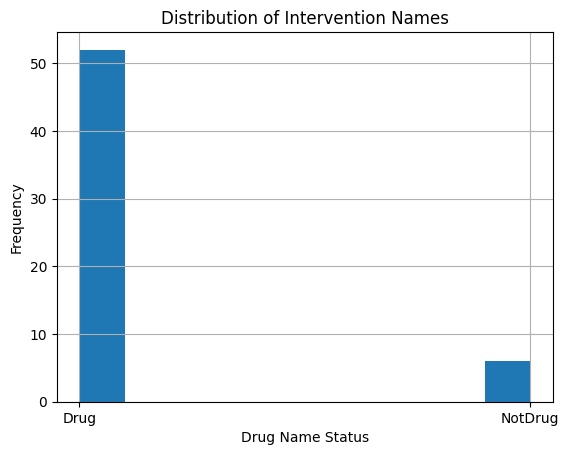

In [58]:
plot = dataset_df['drug_status'].hist()
plot.set_title('Distribution of Intervention Names')
plot.set_xlabel('Drug Name Status')
plot.set_ylabel('Frequency')
plot

In [59]:
drug_status_mapping = {'Drug': 0, 'NotDrug': 1}
dataset_df['drug_status'] = dataset_df['drug_status'].map(drug_status_mapping)

In [60]:
# Renamining column as required to have a label column
df2 = dataset_df[['intervention_names', 'drug_status']]
df2.columns = ['intervention_names', 'labels']
df2.to_csv('dataset.csv', index=False)

In [61]:
!pip install datasets
from datasets import load_dataset

# Load CSV as HuggingFace Dataset
raw_dataset = load_dataset('csv', data_files='dataset.csv')
raw_dataset

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['intervention_names', 'labels'],
        num_rows: 58
    })
})

In [10]:
split = raw_dataset['train'].train_test_split(test_size=0.2, seed = 42)
split

DatasetDict({
    train: Dataset({
        features: ['intervention_names', 'labels'],
        num_rows: 46
    })
    test: Dataset({
        features: ['intervention_names', 'labels'],
        num_rows: 12
    })
})

In [11]:
# Set tokenizer object passing in checkpoint
checkpoint = "dmis-lab/biobert-base-cased-v1.1"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [102]:
# Tokenizer function to do truncation , padding done automatically by trainer
def tokenize_function(batch):
    return tokenizer(batch["intervention_names"], truncation=True)

In [13]:
# Apply tokenizer to train test split using map method
tokenize_dataset = split.map(tokenize_function, batched=True)
tokenize_dataset

Map:   0%|          | 0/46 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/12 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['intervention_names', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 46
    })
    test: Dataset({
        features: ['intervention_names', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 12
    })
})

In [14]:
# Load mode from checkpoint
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
!pip install torchinfo
from torchinfo import summary

In [16]:
summary(model)

Layer (type:depth-idx)                                  Param #
BertForSequenceClassification                           --
├─BertModel: 1-1                                        --
│    └─BertEmbeddings: 2-1                              --
│    │    └─Embedding: 3-1                              22,268,928
│    │    └─Embedding: 3-2                              393,216
│    │    └─Embedding: 3-3                              1,536
│    │    └─LayerNorm: 3-4                              1,536
│    │    └─Dropout: 3-5                                --
│    └─BertEncoder: 2-2                                 --
│    │    └─ModuleList: 3-6                             85,054,464
│    └─BertPooler: 2-3                                  --
│    │    └─Linear: 3-7                                 590,592
│    │    └─Tanh: 3-8                                   --
├─Dropout: 1-2                                          --
├─Linear: 1-3                                           1,538
Total params: 10

In [17]:
# Create training args object
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64)

In [18]:
def compute_metrics(logits_and_labels):
  logits, labels = logits_and_labels
  predictions = np.argmax(logits, axis=-1)
  acc = np.mean(predictions==labels)
  f1 = f1_score(labels, predictions, average='macro')
  return {'accuracy': acc, 'f1': f1}

In [104]:
# Build trainer object
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenize_dataset['train'],
    eval_dataset=tokenize_dataset['test'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [20]:
# Start training process
trainer.train()

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.389551,0.916667,0.478261
2,No log,0.292293,0.916667,0.478261
3,No log,0.274384,0.916667,0.478261
4,No log,0.259776,0.916667,0.478261
5,No log,0.256169,0.916667,0.478261


TrainOutput(global_step=15, training_loss=0.3908354123433431, metrics={'train_runtime': 190.5126, 'train_samples_per_second': 1.207, 'train_steps_per_second': 0.079, 'total_flos': 4615749021960.0, 'train_loss': 0.3908354123433431, 'epoch': 5.0})

In [106]:
!ls ./results

checkpoint-12  checkpoint-15  checkpoint-3  checkpoint-6  checkpoint-9	runs


In [22]:
from transformers import pipeline

In [23]:
savedmodel = pipeline(task='text-classification', model='./results/checkpoint-9')

In [24]:
split['test']

Dataset({
    features: ['intervention_names', 'labels'],
    num_rows: 12
})

In [25]:
test_pred = savedmodel(split['test']['intervention_names'])

In [26]:
test_pred

[{'label': 'LABEL_0', 'score': 0.9259425401687622},
 {'label': 'LABEL_0', 'score': 0.9162322878837585},
 {'label': 'LABEL_0', 'score': 0.9292208552360535},
 {'label': 'LABEL_0', 'score': 0.8428515195846558},
 {'label': 'LABEL_0', 'score': 0.9305948615074158},
 {'label': 'LABEL_0', 'score': 0.8942419290542603},
 {'label': 'LABEL_0', 'score': 0.9259425401687622},
 {'label': 'LABEL_0', 'score': 0.929412841796875},
 {'label': 'LABEL_0', 'score': 0.8954777121543884},
 {'label': 'LABEL_0', 'score': 0.911907434463501},
 {'label': 'LABEL_0', 'score': 0.8935947418212891},
 {'label': 'LABEL_0', 'score': 0.9048320055007935}]

In [28]:
def get_labels(d):
  return int(d['label'].split(sep='_')[1])

test_pred = [get_labels(d) for d in test_pred]

In [29]:
test_pred

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [30]:
# Get accuracy of predictions
print("acc:", accuracy_score(split['test']['labels'], test_pred))

acc: 0.9166666666666666


In [31]:
# Get f1 score
print("f1:", f1_score(split['test']['labels'], test_pred, average='macro'))

f1: 0.4782608695652174


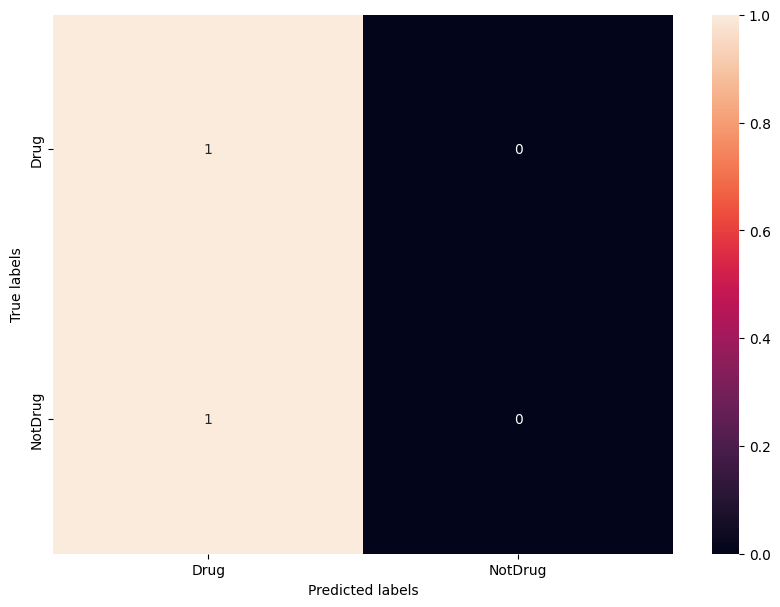

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm):
  classes =  ['Drug', 'NotDrug']
  df_cm = pd.DataFrame(cm, index = classes, columns = [classes])
  plt.figure(figsize = (10,7))
  ax = sns.heatmap(df_cm, annot=True, fmt='g')
  ax.set_xlabel('Predicted labels')
  ax.set_ylabel('True labels')

cm = confusion_matrix(split['test']['labels'], test_pred, normalize='true')
plot_confusion_matrix(cm)

The confusion matrix with a dark square on the 'Drug' label and a blank on the 'NotDrug'shows that the model is only predicting one class correctly.

## Ablation Study

### Cleaning Intervention Names

In [96]:
def clean_intervention_names(name):
  # replace |, +, /, -, %
  name = name.replace('|', ' ')
  name = name.replace('+', ' ')
  name = name.replace('/', ' ')
  name = name.replace('-', ' ')
  name = name.replace('%', ' ')
  # remove numbers after a space
  name = re.sub(r'\s\d+', '', name)
  # remove punctuation
  cleaned_name = re.sub(r'[^\w\s]', '', name)
  return cleaned_name

In [97]:
df3 = df2.copy()
df3['intervention_names'] = df3['intervention_names'].apply(clean_intervention_names)

In [98]:
df3.head()

,intervention_names,labels
0,Nivolumab ipilimumab Nivolumab,0
1,Elotuzumab in combination with pomalidomide an...,0
2,Amitriptyline Flunarizinemg,0
3,Omadacycline Moxifloxacin,0
4,individualized vancomycin dosing based on the ...,0


In [99]:
# Export dataframe to csv
df3.to_csv('dataset3.csv', index=False)

In [100]:
!pip install datasets
from datasets import load_dataset

# Load CSV as HuggingFace Dataset
raw_dataset = load_dataset('csv', data_files='dataset3.csv')
raw_dataset

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['intervention_names', 'labels'],
        num_rows: 58
    })
})

In [101]:
split = raw_dataset['train'].train_test_split(test_size=0.2, seed = 42)
split

DatasetDict({
    train: Dataset({
        features: ['intervention_names', 'labels'],
        num_rows: 46
    })
    test: Dataset({
        features: ['intervention_names', 'labels'],
        num_rows: 12
    })
})

In [103]:
# Set tokenizer object passing in checkpoint
checkpoint = "dmis-lab/biobert-base-cased-v1.1"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

# Tokenizer function to do truncation , padding done automatically by trainer
def tokenize_function(batch):
    return tokenizer(batch["intervention_names"], truncation=True)

# Apply tokenizer to train test split using map method
tokenize_dataset = split.map(tokenize_function, batched=True)
tokenize_dataset

Map:   0%|          | 0/46 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/12 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['intervention_names', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 46
    })
    test: Dataset({
        features: ['intervention_names', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 12
    })
})

In [105]:
# Load mode from checkpoint
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

# Create training args object
training_args = TrainingArguments(
    output_dir="./results3",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64)

def compute_metrics(logits_and_labels):
  logits, labels = logits_and_labels
  predictions = np.argmax(logits, axis=-1)
  acc = np.mean(predictions==labels)
  f1 = f1_score(labels, predictions, average='macro')
  return {'accuracy': acc, 'f1': f1}

# Build trainer object
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenize_dataset['train'],
    eval_dataset=tokenize_dataset['test'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Train model
trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.317830,0.916667,0.478261
2,No log,0.276649,0.916667,0.478261
3,No log,0.261365,0.916667,0.478261
4,No log,0.250379,0.916667,0.478261
5,No log,0.247110,0.916667,0.478261


TrainOutput(global_step=15, training_loss=0.2966369311014811, metrics={'train_runtime': 183.1036, 'train_samples_per_second': 1.256, 'train_steps_per_second': 0.082, 'total_flos': 3983665822560.0, 'train_loss': 0.2966369311014811, 'epoch': 5.0})

In [ ]:
!ls ./results3

In [107]:
from transformers import pipeline
savedmodel = pipeline(task='text-classification', model='./results/checkpoint-9')
test_pred = savedmodel(split['test']['intervention_names'])
test_pred

[{'label': 'LABEL_0', 'score': 0.8646628856658936},
 {'label': 'LABEL_0', 'score': 0.903158962726593},
 {'label': 'LABEL_0', 'score': 0.9101500511169434},
 {'label': 'LABEL_0', 'score': 0.8458414673805237},
 {'label': 'LABEL_0', 'score': 0.9148808121681213},
 {'label': 'LABEL_0', 'score': 0.8642085790634155},
 {'label': 'LABEL_0', 'score': 0.8646628856658936},
 {'label': 'LABEL_0', 'score': 0.9105384945869446},
 {'label': 'LABEL_0', 'score': 0.8774872422218323},
 {'label': 'LABEL_0', 'score': 0.8958157896995544},
 {'label': 'LABEL_0', 'score': 0.866192102432251},
 {'label': 'LABEL_0', 'score': 0.8671775460243225}]

Cross Validation & Learning Rate

In [111]:
from sklearn.model_selection import StratifiedKFold

# Number of splits
n_splits = 5

# Initialize StratifiedKFold
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Assuming tokenize_dataset is your entire dataset
X = tokenize_dataset['train']['input_ids']
y = tokenize_dataset['train']['labels']

# Split the dataset into k consecutive folds
folds = list(skf.split(X, y))

In [112]:

# Store the evaluation results for each fold
eval_results = []

for fold, (train_ids, val_ids) in enumerate(folds):
    # Split the dataset into the current train and validation sets
    train_dataset = tokenize_dataset['train'].select(train_ids)
    val_dataset = tokenize_dataset['train'].select(val_ids)

    # Load model from checkpoint
    model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

    # Define training arguments
    training_args = TrainingArguments(
        output_dir=f"./results_fold_{fold}",
        evaluation_strategy="epoch",
        save_strategy="epoch",
        learning_rate=1e-5,
        num_train_epochs=5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=64
    )

    # Initialize Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )

    # Train and evaluate the model
    trainer.train()
    eval_result = trainer.evaluate()
    eval_results.append(eval_result)

    # Save the model after training each fold (optional)
    model.save_pretrained(f"./model_fold_{fold}")

# Calculate and print the average evaluation results across all folds
average_eval_results = {metric: np.mean([result[metric] for result in eval_results]) for metric in eval_results[0]}
print("Average Evaluation Results:", average_eval_results)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.674350,0.600000,0.523810
2,No log,0.569513,0.900000,0.473684
3,No log,0.509555,0.900000,0.473684
4,No log,0.478642,0.900000,0.473684
5,No log,0.467147,0.900000,0.473684


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.512503,0.888889,0.470588
2,No log,0.494035,0.888889,0.470588
3,No log,0.465447,0.888889,0.470588
4,No log,0.444867,0.888889,0.470588
5,No log,0.436859,0.888889,0.470588


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.522263,0.888889,0.470588
2,No log,0.472769,0.888889,0.470588
3,No log,0.444946,0.888889,0.470588
4,No log,0.430213,0.888889,0.470588
5,No log,0.424807,0.888889,0.470588


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.516648,0.888889,0.470588
2,No log,0.472705,0.888889,0.470588
3,No log,0.446975,0.888889,0.470588
4,No log,0.433028,0.888889,0.470588
5,No log,0.427997,0.888889,0.470588


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.512255,0.888889,0.470588
2,No log,0.472661,0.888889,0.470588
3,No log,0.444862,0.888889,0.470588
4,No log,0.429732,0.888889,0.470588
5,No log,0.424544,0.888889,0.470588


Average Evaluation Results: {'eval_loss': 0.43627099990844725, 'eval_accuracy': 0.8911111111111112, 'eval_f1': 0.4712074303405573, 'eval_runtime': 0.93932, 'eval_samples_per_second': 10.6096, 'eval_steps_per_second': 1.1556000000000002, 'epoch': 5.0}
